In [ ]:
!pip install peartree
!pip install osmnx
!pip install ripser
!pip install persim
!pip install folium

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import peartree as pt
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import numpy as np
import os
import pandas as pd
import csv
from ripser import ripser
from persim import plot_diagrams
import math
import requests
import time
import folium
from IPython.display import display
%matplotlib inline

In [5]:
path = '/content/drive/MyDrive/GTFS/Local_Transit'

In [6]:
def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    radius = 6371.0  # Earth's radius in kilometers

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c

    return distance

def create_transit_graph(path, lat_range, lon_range):

    # Initialize the graph
    transit_graph = nx.DiGraph()

    #Create dictionaries to store stop, parent and trip information
    stop_dict = {}
    parent_station_dict = {}
    trip_to_previous_stop = {}

    # Load stops.txt to populate the dictionaries
    stops_file = open(path + '/stops.txt', 'r', encoding='utf-8-sig')
    stops_reader = csv.reader(stops_file)
    next(stops_reader)  # Skip the header row

    for stop in stops_reader:
        stop_id = stop[2]
        latitude = float(stop[3])
        longitude = float(stop[4])

        if lat_range[0] <= latitude <= lat_range[1] and lon_range[0] <= longitude <= lon_range[1]:
            stop_name = stop[0]
            stop_dict[stop_id] = (stop_name, latitude, longitude)
            parent_station = stop[1]
            if parent_station:
                parent_station_dict[stop_id] = parent_station

    # Load stop_times.txt to create nodes and edges in the transit graph
    stop_times_file = open(path + '/stop_times.txt', 'r', encoding='utf-8-sig')
    stop_times_reader = csv.reader(stop_times_file)
    next(stop_times_reader)  # Skip the header row

    for stop_time in stop_times_reader:
        trip_id = stop_time[0]
        stop_id = stop_time[3]

        # Connect stops based on the same trip
        if stop_id in stop_dict:
            transit_graph.add_node(stop_id)

            previous_stop_id = trip_to_previous_stop.get(trip_id)
            if previous_stop_id:
                edge_weight = haversine_distance(
                    (stop_dict[previous_stop_id][1], stop_dict[previous_stop_id][2]),
                    (stop_dict[stop_id][1], stop_dict[stop_id][2])
                )
                transit_graph.add_edge(previous_stop_id, stop_id, weight=edge_weight)
            trip_to_previous_stop[trip_id] = stop_id

            parent_station = parent_station_dict.get(stop_id)
            if parent_station and parent_station in stop_dict:
                edge_weight = haversine_distance(
                    (stop_dict[parent_station][1], stop_dict[parent_station][2]),
                    (stop_dict[stop_id][1], stop_dict[stop_id][2])
                )
                transit_graph.add_edge(parent_station, stop_id, weight=edge_weight)

    # Close the GTFS files
    stops_file.close()
    stop_times_file.close()

    return transit_graph, stop_dict


Verification of networks using Folium

In [7]:
def plot_transit_graph_on_map(transit_graph, stop_dict, city_name, path):
    """Plot the transit graph on a map and display it."""

    #Calculation of average latitude and longitude of city networks to verify for correctness and to center the folium map around the average lat, lon
    avg_lat = sum([coords[1] for coords in stop_dict.values()]) / len(stop_dict)
    avg_lon = sum([coords[2] for coords in stop_dict.values()]) / len(stop_dict)
    print(avg_lat,avg_lon)
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=13)

    #Adding nodes (stops) to the folium map
    for stop_id, (stop_name, lat, lon) in stop_dict.items():
        folium.CircleMarker(
            location=[lat, lon],
            radius=5,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=1,
            tooltip=stop_name
        ).add_to(m)

    #Adding edges (routes) to the folium map
    for edge in transit_graph.edges():
        coord1 = stop_dict[edge[0]][1], stop_dict[edge[0]][2]
        coord2 = stop_dict[edge[1]][1], stop_dict[edge[1]][2]
        folium.PolyLine([coord1, coord2], color="blue").add_to(m)

    # Save the map to an HTML file
    filename = os.path.join(path, f"{city_name}_transit_map.html")
    m.save(filename)
    print(f"Saved map for {city_name} to {filename}")

    return m

In [ ]:
city_lat_lon_ranges = {
    'Aachen': ((50.7, 50.8), (6.0, 6.2)),
    'Berlin': ((52.3, 52.7), (13.2, 13.6)),
    'Frankfurt': ((50.0, 50.2), (8.6, 9.0)),
    'Hamburg': ((53.4, 53.7), (9.8, 10.2)),
    'Leipzig': ((51.2, 51.5), (12.2, 12.7)),
    'Munich': ((48.0610, 48.2480), (11.3600, 11.7220)),
    'Cologne': ((50.8300, 51.0500), (6.7900, 7.1100)),
    'Stuttgart': ((48.6900, 48.8600), (9.1200, 9.3100)),
    'Dortmund': ((51.4200, 51.6000), (7.3400, 7.6500)),
    'Duesseldorf': ((51.1500, 51.3100), (6.6500, 6.9800))
}


#Plot the networks and the respective persistence diagrams
for city_name, (lat_range, lon_range) in city_lat_lon_ranges.items():
    transit_graph, stops = create_transit_graph(path, lat_range, lon_range)
    #plot_transit_graph_on_map(transit_graph, stops, city_name, path)

    '''
    print(f"Map for {city_name}")
    m.save(f"{city_name}_map.html")  # Saves the map as an HTML file
    display(m)
    '''

Euler curves

In [8]:
def normalise(values):
    min_val = min(values)
    max_val = max(values)

    range = max_val - min_val

    return [(val-min_val)/range for val in values]

def euler_char(graph):
    return graph.number_of_nodes() - graph.number_of_edges()

def filtration_by_edge_weight(graph, steps=100):
    edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)

    thresholds = np.linspace(min_weight, max_weight, steps)
    euler_chars = []

    for threshold in thresholds:
        subgraph_edges = [(u, v) for u, v, data in graph.edges(data=True) if data['weight'] <= threshold]
        subgraph = nx.Graph()
        subgraph.add_edges_from(subgraph_edges)
        euler_chars.append(euler_char(subgraph))

    #Normalizing the euler chars and threshold values
    thresholds_norm = normalise(thresholds)
    euler_chars_norm = normalise(euler_chars)

    return thresholds_norm, euler_chars_norm

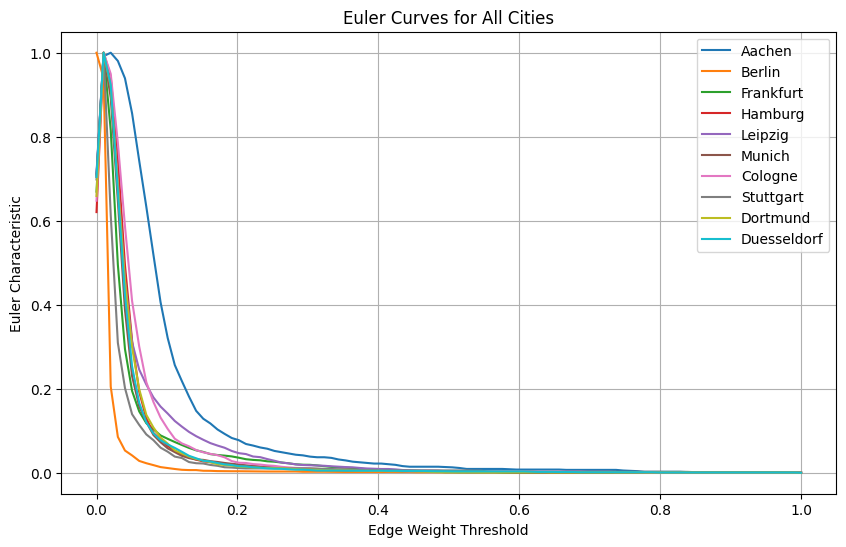

In [9]:
city_lat_lon_ranges = {
    'Aachen': ((50.7, 50.8), (6.0, 6.2)),
    'Berlin': ((52.3, 52.7), (13.2, 13.6)),
    'Frankfurt': ((50.0, 50.2), (8.6, 9.0)),
    'Hamburg': ((53.4, 53.7), (9.8, 10.2)),
    'Leipzig': ((51.2, 51.5), (12.2, 12.7)),
    'Munich': ((48.0610, 48.2480), (11.3600, 11.7220)),
    'Cologne': ((50.8300, 51.0500), (6.7900, 7.1100)),
    'Stuttgart': ((48.6900, 48.8600), (9.1200, 9.3100)),
    'Dortmund': ((51.4200, 51.6000), (7.3400, 7.6500)),
    'Duesseldorf': ((51.1500, 51.3100), (6.6500, 6.9800))
}

#Initialize plot dimensions
plt.figure(figsize=(10, 6))

#Plot the networks and the respective persistence diagrams
for city_name, (lat_range, lon_range) in city_lat_lon_ranges.items():
    transit_graph, stops = create_transit_graph(path, lat_range, lon_range)

    thresholds, euler_chars = filtration_by_edge_weight(transit_graph)
    plt.plot(thresholds, euler_chars, label=city_name)

plt.xlabel('Edge Weight Threshold')
plt.ylabel('Euler Characteristic')
plt.title('Euler Curves for All Cities')
plt.legend()
plt.grid(True)
#plt.axis('equal')
#plt.tight_layout()

#Plot on the same coordinate system
plt.show()

Creating a Pytorch Geometric Dataset

In [ ]:
!pip install torch_geometric

In [57]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.data import InMemoryDataset

import networkx as nx

def nx_to_pyg_data(graph):
    """
    Convert a networkx graph to a PyTorch Geometric Data object using only the edge weights as features.
    """
    # Create a mapping from nodes to integers
    node_mapping = {node: i for i, node in enumerate(graph.nodes())}

    # Get the adjacency information with remapped node indices
    edge_index = torch.tensor([(node_mapping[u], node_mapping[v]) for u, v in graph.edges()]).t().contiguous()

    # Extract edge weights
    edge_weights = [data['weight'] for _, _, data in graph.edges(data=True)]
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)  # make it a 2D tensor

    # Return as PyTorch Geometric Data
    return Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=graph.number_of_nodes())

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, nx_graphs, transform=None, pre_transform=None, pre_filter=None):
        self.nx_graphs = nx_graphs
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []  # We're directly passing in NetworkX graphs so we don't need raw file names

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # No downloading needed as we're directly passing in NetworkX graphs
        pass

    def process(self):
        # Convert the NetworkX graphs to PyTorch Geometric Data objects
        data_list = [nx_to_pyg_data(graph) for graph in self.nx_graphs]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [58]:
city_lat_lon_ranges = {
    'Aachen': ((50.7, 50.8), (6.0, 6.2)),
    'Berlin': ((52.3, 52.7), (13.2, 13.6)),
    'Frankfurt': ((50.0, 50.2), (8.6, 9.0)),
    'Hamburg': ((53.4, 53.7), (9.8, 10.2)),
    'Leipzig': ((51.2, 51.5), (12.2, 12.7)),
    'Munich': ((48.0610, 48.2480), (11.3600, 11.7220)),
    'Cologne': ((50.8300, 51.0500), (6.7900, 7.1100)),
    'Stuttgart': ((48.6900, 48.8600), (9.1200, 9.3100)),
    'Dortmund': ((51.4200, 51.6000), (7.3400, 7.6500)),
    'Duesseldorf': ((51.1500, 51.3100), (6.6500, 6.9800))
}

city_graphs = []

#Plot the networks and the respective persistence diagrams
for city_name, (lat_range, lon_range) in city_lat_lon_ranges.items():
    transit_graph, stops = create_transit_graph(path, lat_range, lon_range)
    city_graphs.append(transit_graph)


dataset = MyOwnDataset(root = path, nx_graphs = city_graphs)

In [59]:
len(dataset)

10

In [60]:
data = dataset[0]
print(data)

Data(edge_index=[2, 2309], edge_attr=[2309, 1])


In [61]:
data = dataset[1]
print(data)

Data(edge_index=[2, 16341], edge_attr=[16341, 1])


In [63]:
data.num_nodes

10059

In [64]:
data.num_edges

16341

In [65]:
data.has_isolated_nodes()

True

In [66]:
data.has_self_loops()

True

In [67]:
data.num_node_features

0

In [68]:
data.is_directed()

True

In [69]:
dataset.num_classes

0

In [70]:
from torch_geometric.loader import DataLoader
dataset = MyOwnDataset(root = path, nx_graphs = city_graphs)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [71]:
for data in loader:
    print(data)

DataBatch(edge_index=[2, 73786], edge_attr=[73786, 1], batch=[45855], ptr=[11])
